In [1]:
# Import 
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *

np.set_printoptions(threshold=sys.maxsize)

size_board = 4

## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)
S,X,allowed_a=env.Initialise_game(50)

# Weights dimentions for initialisation in the DeepRL function
rows = len(allowed_a)
cols = len(X)

In [2]:
## DEFINE THE EPSILON-GREEDY POLICY

def EpsilonGreedy_Policy(Qvalues, epsilon, a, seed):
    
    np.random.seed(seed) # seed value to use the same set of random numbers

    N_a=np.shape(Qvalues)[0]

    rand_value=np.random.uniform(0,1)


    rand_a=rand_value<epsilon

    if rand_a==True:
    # choose a random action from the legal actions         

        action = np.random.permutation(a)[0]

    else:        
    # find all the legal action q vals and find the arg max for the legal actions        

        legal_qs = Qvalues[a]
        max_qval_a=np.argmax(legal_qs)
        action = a[max_qval_a]
            
    return action

In [3]:
## Let's define Adam, see notebook Adam's playgroud for more information

class Adam:

    def __init__(self, Params, beta1):
        
        N_dim=np.shape(np.shape(Params))[0] # It finds out if the parameters given are in a vector (N_dim=1) or a matrix (N_dim=2)
        
        # INITIALISATION OF THE MOMENTUMS
        if N_dim==1:
               
            self.N1=np.shape(Params)[0]
            
            self.mt=np.zeros([self.N1])
            self.vt=np.zeros([self.N1])
        
        if N_dim==2:
            
            self.N1=np.shape(Params)[0]
            self.N2=np.shape(Params)[1]
        
            self.mt=np.zeros([self.N1,self.N2])
            self.vt=np.zeros([self.N1,self.N2])
        
        # HYPERPARAMETERS OF ADAM
        self.beta1=beta1
        self.beta2=0.999
        
        self.epsilon=10**(-8)
        
        # COUNTER OF THE TRAINING PROCESS
        self.counter=0
        
        
    def Compute(self,Grads):
                
        self.counter=self.counter+1
        
        self.mt=self.beta1*self.mt+(1-self.beta1)*Grads
        
        self.vt=self.beta2*self.vt+(1-self.beta2)*Grads**2
        
        mt_n=self.mt/(1-self.beta1**self.counter)
        vt_n=self.vt/(1-self.beta2**self.counter)
        
        New_grads=mt_n/(np.sqrt(vt_n)+self.epsilon)
        
        return New_grads

beta1=0.9 # First order momentum for Adam

# The function below returns the reward and the number of moves at the end of each episode of the chess game. Its set to 10000 episodes in total.  

Arguments taken : 
- model : "can be sarsa" or "q-learning"
- bet : a continous number for the hyperparameter Beta
- gam : a continous number for the hyperparameter Beta
- r : fixed to the variable rows which is the number of actions (dependant on the chess board size)
- c : fixed to the variable cols which is the number of states (dependant on the chess board size)

Returns : 
- N_moves_save : An array where each entry represents the number of moves to finish an episode of the chess game 
- R_save : An array where each entry represents the total reward at the end of each episode of the chess game
    

In [4]:
def DeepRL(model, bet, gam, r = rows, c = cols): 
    
    np.random.seed(50)  # random seed for the randon Q value initialisation
    
    N_episodes = 10000  # THE NUMBER OF GAMES TO BE PLAYED 
    
    # HYPERPARAMETERS 
    
    epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
    beta = bet          # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING
    gamma = gam         # THE DISCOUNT FACTOR
    eta = 0.0035        # THE LEARNING RATE

    Ran = np.random.randn(r, c)/1000  # random Q - value matrix for the weights 
    W = Ran 
    
    # Adam initialisation of weights 
    Adam_W=Adam(W,beta1)


    # SAVING VARIABLES (rewards and steps)
    R_save = np.zeros([N_episodes, 1])
    N_moves_save = np.zeros([N_episodes, 1])
    
    # another seed counter that gets passed into the Eplison greedy policy function,
    # so that it always returns the same sequence of random numbers when choosing an action
    seed_counter = 0 
    
    for n in range(N_episodes):
        
        ## DECAYING EPSILON for lower rate of exploration in the future 
        epsilon = epsilon_0 / (1 + beta * n)   

        Done=0                                    ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1                                     ## COUNTER FOR NUMBER OF ACTIONS

        S,X,allowed_a=env.Initialise_game(n)      ## INITIALISE GAME, and enter the seed value so it returns
                                                  ## the same sequence of states
        
        while Done==0:                            ## START THE EPISODE
            
            Qvalues=np.matmul(W,X)
            
            if i == 1 or model != "sarsa":
                # if its the first step use ep greedy to select action
                # or if the model is not sarsa then continue using ep greedy to select next action
                a,_=np.where(allowed_a==1)
                a_agent=EpsilonGreedy_Policy(Qvalues,epsilon, a, seed_counter)
                
            else:
                # if the algo is sarsa then update the action to the action chosen to evaluate the reward in the previous step
                a_agent = a_agent1

            S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)

#######################################################################################################
            if model == "sarsa":
                
                ## THE EPISODE HAS ENDED
                if Done==1:
                    
                    # Compute the delta
                    delta=R-Qvalues[a_agent]

                    delta_W = delta*X

                    # Update the Weights
                    W[a_agent,:] = W[a_agent,:] + eta*Adam_W.Compute(delta_W)[a_agent,:]

                    # Calculate the total reward and the total number of steps
                    R_save[n]=np.copy(R)
                    N_moves_save[n]=np.copy(i)
                   
                    seed_counter += 1
                    
                    break

                # Find the Qvalues
                Qvalues1=np.matmul(W,X_next)

                # Make an action with epsilon-greedy policy
                a1,_=np.where(allowed_a_next==1)
                a_agent1=EpsilonGreedy_Policy(Qvalues1, epsilon, a1, seed_counter+1)

                # Compute the delta
                delta=R+gamma*Qvalues1[a_agent1]-Qvalues[a_agent]

                delta_W = delta*X

                # Update the weights
                W[a_agent,:] = W[a_agent,:] + eta*Adam_W.Compute(delta_W)[a_agent,:]

#######################################################################################################
            elif model == "q-learning":
        
                if Done == 1:

                    # Compute the delta
                    delta = R - Qvalues[a_agent]
                    
                    delta_W = delta*X

                    # Update the Weights
                    W[a_agent,:] = W[a_agent,:] + eta*Adam_W.Compute(delta_W)[a_agent,:]

                    # Calculate the total reward and the total number of steps
                    R_save[n] = np.copy(R)
                    N_moves_save[n] = np.copy(i)
                    
                    seed_counter += 1
                    break


                a_agent1 = None
        
                # Find the expected value of Q for the next state
                a_next,_ = np.where(allowed_a_next == 1)
                Qvalues1 = np.matmul(W, X_next)
                Qvalues_next = Qvalues1[a_next]
                Qvalues_next_max = np.max(Qvalues_next)  # find the greedy action

                # Compute the delta
                delta = R + gamma*Qvalues_next_max - Qvalues[a_agent]

                delta_W = delta*X

                # Update the weights
                W[a_agent,:] = W[a_agent,:] + eta*Adam_W.Compute(delta_W)[a_agent,:]

#######################################################################################################

            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S=np.copy(S_next)
            X=np.copy(X_next)
            allowed_a=np.copy(allowed_a_next)

            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
            seed_counter += 1
    
    return N_moves_save, R_save # returns the 


# The code in the next cell generates plots to compare Deep Sarsa and Deep Q - learning. 

Generates the following plots : 

- Average number of moves per game 
- Average reward per game 

The Hyperparameters Beta is set to 0.0001 and Gamma is set to 0.7

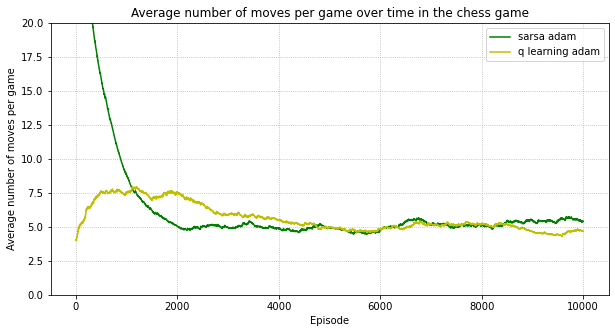

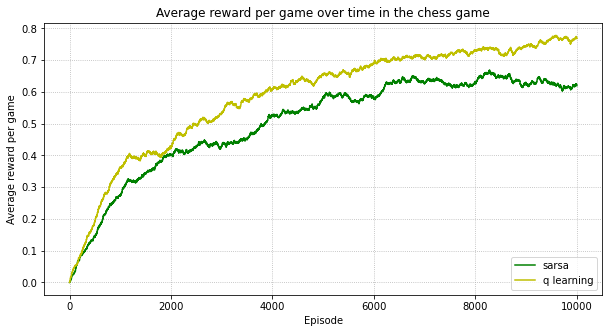

In [5]:
models = ["sarsa", "q-learning"]

results = {}

for index, model_name in enumerate(models):
    Moves, Rewards = DeepRL(model_name, 0.0001, 0.7) # using default values
    
    moves_df = pd.DataFrame(Moves, columns = ["moves"])
    moves_df_average = moves_df.ewm(span=1000, adjust=False).mean()
    
    rewards_df = pd.DataFrame(Rewards, columns = ["Rewards"])
    rewards_df_average = rewards_df.ewm(span=1000, adjust=False).mean()
    
    results[model_name] = {"moves": moves_df, "moves_A": moves_df_average, "rewards": rewards_df, "rewards_A": rewards_df_average}

plt.figure(figsize=(10, 5))
plt.plot(results["sarsa"]["moves_A"], 'g-', label='sarsa adam')
plt.plot(results["q-learning"]["moves_A"], 'y-', label='q learning adam')
plt.title("Average number of moves per game over time in the chess game")
plt.ylabel('Average number of moves per game')
plt.xlabel('Episode')
plt.grid(linestyle=':')
plt.ylim([0, 20])
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(results["sarsa"]["rewards_A"], 'g-', label='sarsa')
plt.plot(results["q-learning"]["rewards_A"], 'y-', label='q learning')
plt.title("Average reward per game over time in the chess game")
plt.ylabel('Average reward per game')
plt.xlabel('Episode')
plt.grid(linestyle=':')
plt.legend(loc='lower right')
plt.show()

# The code below generates plots to compare the effects of changing the Beta hyperparameter in Deep Sarsa and Deep Q - learning. 

Generates the following plots : 

- Average number of moves per game for Deep Sarsa (for 3 different Beta values)
- Average reward per game per game for Deep Sarsa (for 3 different Beta values)
- Average number of moves per game for Deep Q - leanring (for 3 different Beta values)
- Average reward per game per game for Deep Q - learning (for 3 different Beta values)

The Hyperparameter Gamma is set to 0.7

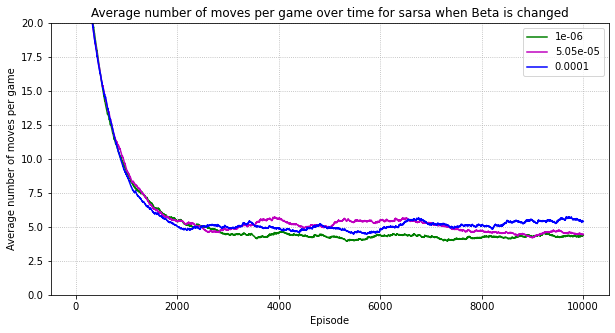

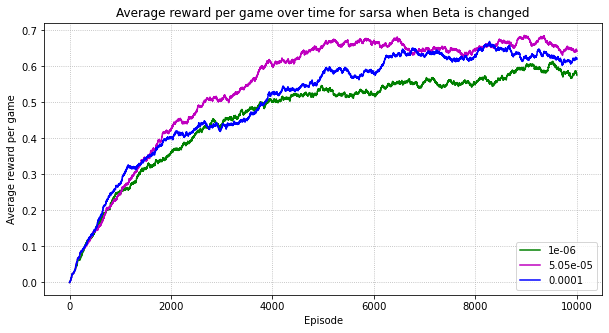

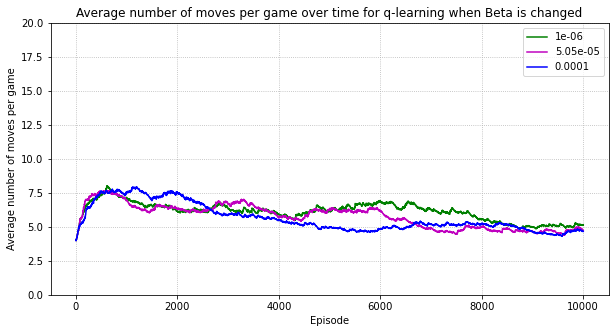

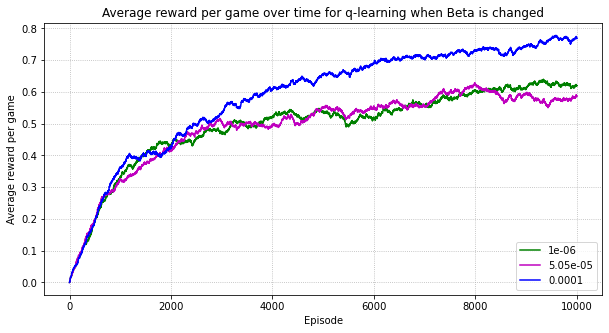

In [6]:
index_counter=['one', 'two', 'three']
b_params = np.linspace(0.000001, 0.0001, num=3)

models = ["sarsa", "q-learning"]
results_bet = {}

for index1, model_name in enumerate(models):
    results_bet[model_name] = {}
        
    for index, beta in enumerate(b_params):
        
        Moves, Rewards = DeepRL(model_name, beta, 0.7) # using default values
        moves_df_B = pd.DataFrame(Moves, columns = ["moves"])
        moves_df_average_B = moves_df_B.ewm(span=1000, adjust=False).mean()
        
        rewards_df_B = pd.DataFrame(Rewards, columns = ["Rewards"])
        rewards_df_average_B = rewards_df_B.ewm(span=1000, adjust=False).mean()
    
        results_bet[model_name][index_counter[index]] = {"moves": moves_df_B, "moves_A": moves_df_average_B, "rewards": rewards_df_B, "rewards_A": rewards_df_average_B}

    plt.figure(figsize=(10, 5))
    plt.plot(results_bet[model_name]["one"]["moves_A"], 'g-', label=f"{b_params[0]}")
    plt.plot(results_bet[model_name]["two"]["moves_A"], 'm-', label=f"{b_params[1]}")
    plt.plot(results_bet[model_name]["three"]["moves_A"], 'b-', label=f"{b_params[2]}")
    plt.title(f"Average number of moves per game over time for {model_name} when Beta is changed")
    plt.ylabel('Average number of moves per game')
    plt.xlabel('Episode')
    plt.grid(linestyle=':')
    plt.legend(loc='upper right')
    plt.ylim([0, 20])
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(results_bet[model_name]["one"]["rewards_A"], 'g-', label=f"{b_params[0]}")
    plt.plot(results_bet[model_name]["two"]["rewards_A"], 'm-', label=f"{b_params[1]}")
    plt.plot(results_bet[model_name]["three"]["rewards_A"], 'b-', label=f"{b_params[2]}")
    plt.title(f"Average reward per game over time for {model_name} when Beta is changed")
    plt.ylabel('Average reward per game')
    plt.xlabel('Episode')
    plt.grid(linestyle=':')
    plt.legend(loc='lower right')
    plt.show()
    

# The code below generates plots to compare the effects of changing the Gamma hyperparameter in Deep Sarsa and Deep Q - learning. 

Generates the following plots : 

- Average number of moves per game for Deep Sarsa (for 3 different Gamma values)
- Average reward per game per game for Deep Sarsa (for 3 different Gamma values)
- Average number of moves per game for Deep Q - leanring (for 3 different Gamma values)
- Average reward per game per game for Deep Q - learning (for 3 different Gamma values)

The Hyperparameter Beta is set to 0.0001. 

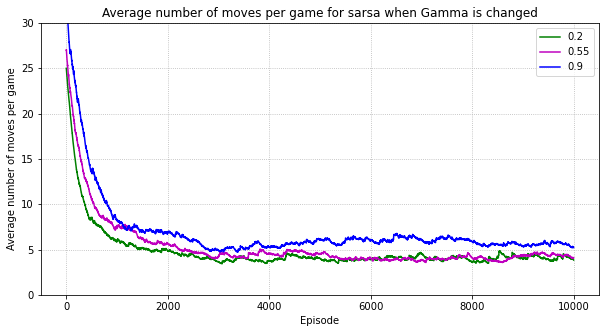

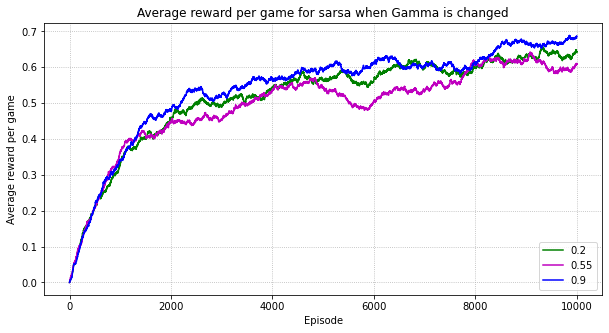

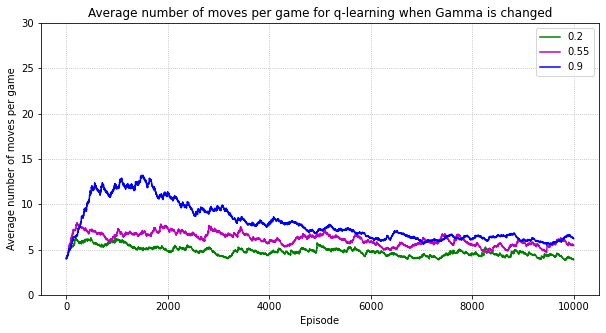

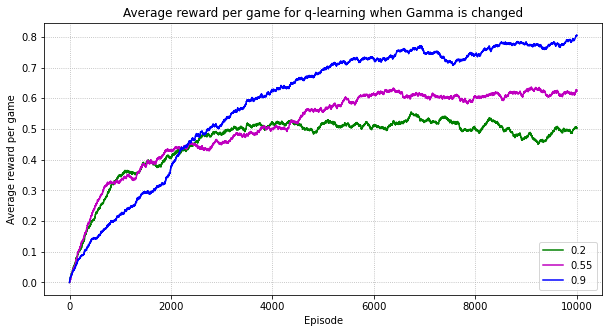

In [7]:
index_counter=['one', 'two', 'three']
g_params = np.linspace(0.2, 0.9, num=3)
models = ["sarsa", "q-learning"]
results_gam = {}

for index1, model_name in enumerate(models):
    results_gam[model_name] = {}
    for index, gamma in enumerate(g_params):
        
        Moves, Rewards = DeepRL(model_name, 0.0001, gamma) # using default values
        
        moves_df_G = pd.DataFrame(Moves, columns = ["moves"])
        moves_df_average_G = moves_df_G.ewm(span=500, adjust=False).mean()
        
        rewards_df_G = pd.DataFrame(Rewards, columns = ["Rewards"])
        rewards_df_average_G = rewards_df_G.ewm(span=1000, adjust=False).mean()
        
        results_gam[model_name][index_counter[index]] = {"moves": moves_df_G, "moves_A": moves_df_average_G, "rewards": rewards_df_G, "rewards_A": rewards_df_average_G}
    
    plt.figure(figsize=(10, 5))
    plt.plot(results_gam[model_name]["one"]["moves_A"], 'g-', label=f"{g_params[0]}")
    plt.plot(results_gam[model_name]["two"]["moves_A"], 'm-', label=f"{g_params[1]}")
    plt.plot(results_gam[model_name]["three"]["moves_A"], 'b-', label=f"{g_params[2]}")
    plt.title(f"Average number of moves per game for {model_name} when Gamma is changed")
    plt.ylabel('Average number of moves per game')
    plt.xlabel('Episode')
    plt.grid(linestyle=':')
    plt.ylim([0, 30])
    plt.legend(loc='upper right')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(results_gam[model_name]["one"]["rewards_A"], 'g-', label=f"{g_params[0]}")
    plt.plot(results_gam[model_name]["two"]["rewards_A"], 'm-', label=f"{g_params[1]}")
    plt.plot(results_gam[model_name]["three"]["rewards_A"], 'b-', label=f"{g_params[2]}")
    plt.title(f"Average reward per game for {model_name} when Gamma is changed")
    plt.ylabel('Average reward per game')
    plt.xlabel('Episode')
    plt.grid(linestyle=':')
    plt.legend(loc='lower right')
    plt.show()